In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME= "/mnt/temp_dd/igrida-fs1/macher/config_bdd.csv" # "./config_bdd.csv" 

# sanity check CSV
with open(TUXML_CSV_FILENAME, "r") as file:
    k = file.readline()
    t = k.split(",")
    s = set(t)
    assert(len(t) == len(s)) # unique number of options/features/column names

# parsing for real with pandas 
rawtuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

basic_head = ["cid", "time", "date"] # "compile"
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]


### basic stats about options and remove of unique values 
## could be improved 

tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in rawtuxdata:
    ft = rawtuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
    else:
        if not (col in size_methods): 
            non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
# non_tristate_options.remove('LZO') # ('vmlinux')

# we want to keep measurements (that are not tristate ;)) 
# non_tristate_options = list(set(non_tristate_options) - set(size_methods))

#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print("Original size (#configs/#options) of the dataset " + str(rawtuxdata.shape))
print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))

# maybe we can drop options with only one unique value (no interest for machine learning)
# TODO: maybe we can rely on more traditional feature reduction techniques
# TODO: need to think about *when* to apply the removal 
rawtuxdata.drop(columns=ftuniques,inplace=True) 
## non_tristate_options include basic stuff like date, time, cid but also string/numerical options
print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))


print ("Predictor variables: " + str(rawtuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()


    



/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1150,6015,6026,6717,7350,7676,7726,8507,9949,10442) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original size (#configs/#options) of the dataset (53910, 12798)
Number of options with only one value (eg always y): (2900, 1)
Non tri-state value options (eg string or integer or hybrid values): (173, 1) 
Predictor variables: 9725


In [2]:
'X86_64' in ftuniques, 'DEBUG_INFO' in ftuniques, 'GCOV_PROFILE_ALL' in ftuniques, 'KASAN' in ftuniques, 'UBSAN_SANITIZE_ALL' in ftuniques, 'RELOCATABLE' in ftuniques, 'XFS_DEBUG' in ftuniques, 'AIC7XXX_BUILD_FIRMWARE' in ftuniques, 'AIC79XX_BUILD_FIRMWARE' in ftuniques, 'WANXL_BUILD_FIRMWARE' in ftuniques

(False, False, False, False, False, False, False, False, False, False)

In [3]:
if 'RELOCATABLE' in rawtuxdata.columns:
    print(rawtuxdata.query("RELOCATABLE == 'y'")[['cid', 'RELOCATABLE']], rawtuxdata.query("RELOCATABLE == 'y'").shape)

         cid RELOCATABLE
0      40000           y
1      40001           y
5      40005           y
7      40007           y
9      40009           y
10     40010           y
11     40011           y
12     40012           y
13     40013           y
14     40014           y
15     40015           y
16     40016           y
17     40017           y
20     40020           y
21     40021           y
23     40023           y
27     40027           y
28     40028           y
29     40029           y
30     40030           y
31     40031           y
32     40032           y
33     40033           y
34     40034           y
38     40038           y
41     40041           y
43     40043           y
44     40044           y
46     40046           y
47     40047           y
...      ...         ...
53717  94197           y
53721  94201           y
53722  94202           y
53727  94207           y
53729  94209           y
53737  94217           y
53752  94232           y
53758  94238           y


In [ ]:
print("Data exploration")

In [4]:
# BUGS EXPLORATION
def bug_exploration():
    rawtuxdata.query("AIC7XXX_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("AIC79XX_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("WANXL_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'n' & DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'y' & DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'n' & DRM_VBOXVIDEO == 'm'")[['cid', 'vmlinux']]
    return rawtuxdata.query("DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]

#bug_exploration()





In [5]:
#rawtuxdata[rawtuxdata['X86_64'] == 'n']
#rawtuxdata.query("X86_64 == 'n'")

In [6]:
#rawtuxdata[(rawtuxdata['DEBUG_INFO'] == 'n') & (rawtuxdata['GCOV_PROFILE_ALL'] == 'n') & (rawtuxdata['KASAN'] == 'n') & (rawtuxdata['MODULES'] == 'y')]
# rawtuxdata.query("(DEBUG_INFO == 'n') & (GCOV_PROFILE_ALL == 'n') & (KASAN == 'n') & (MODULES == 'y')")
#rawtuxdata.query("(DEBUG_INFO == 'n') & (GCOV_PROFILE_ALL == 'n') & (KASAN == 'n')").shape, rawtuxdata.shape


In [7]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072][['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]
tiny_data = rawtuxdata.query("vmlinux == 1168072") #tiny config for X86_32
#if (len(tiny_data) > 0):
#    print(tiny_data[['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']])

In [8]:
#rawtuxdata[rawtuxdata['vmlinux'] == -1]
rawtuxdata.query("vmlinux == -1")

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
25,40025,2018-06-14 00:39:15,610.609,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,n,n,n,m,n,n,n
41,40041,2018-06-14 00:40:59,1300.550,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,n,n,n,n,n,m,y
104,40104,2018-06-14 00:48:01,304.353,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,n,y,n,n,n,m,n
113,40113,2018-06-14 00:49:13,218.127,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,n,n,n,y,n,m,n
147,40147,2018-06-14 00:52:35,293.928,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,n,n,n,n,n,y,y
158,40158,2018-06-14 00:54:41,271.530,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,y,n,n,n,n,m,y
197,40197,2018-06-14 00:58:34,663.868,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,n,n,n,n,n,y,n
225,40225,2018-06-14 01:01:14,534.840,-1,-1,-1,-1,-1,-1,-1,...,n,m,y,y,n,n,y,n,n,n
253,40253,2018-06-14 01:04:36,476.935,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,y,n,n,n,n,y,n
264,40264,2018-06-14 01:06:04,307.815,-1,-1,-1,-1,-1,-1,-1,...,y,y,y,n,n,y,y,y,y,n


In [9]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]['MODULES']
rawtuxdata.query("vmlinux == 1168072")['MODULES'] #tiny config for X86_32

16272    n
16273    n
16274    n
30287    n
30291    n
30300    n
30301    n
46237    n
Name: MODULES, dtype: object

In [10]:
# playing a bit with the data 
rawtuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

#rawtuxdata[:5]
rawtuxdata[:20]['vmlinux']
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

0      64609912
1      99376784
2      50206112
3      50684064
4      21991648
5     145021888
6      15892120
7      59728112
8      54816520
9      21209240
10     76329552
11     18178920
12     26611096
13     31767656
14     29977088
15     37789808
16     92816320
17    224313360
18     64802928
19     38711576
Name: vmlinux, dtype: int64

In [11]:
rawtuxdata.shape, rawtuxdata.query("vmlinux != -1").shape

((53910, 9898), (50975, 9898))

In [12]:
print("some configurations may have X86_32 (coz we have tested/tried some options and there are in the database)")
# we only keep X86_64 configurations
#rawtuxdata = rawtuxdata[rawtuxdata['X86_64'] == 'y'] ### TODO: I've impression it's not the most effective way (wrt memory) to filter 
if 'X86_64' in rawtuxdata.columns:
    print(rawtuxdata['X86_64'].describe())
    rawtuxdata.query("X86_64 == 'y'", inplace=True)
rawtuxdata.info(memory_usage='deep')

some configurations may have X86_32 (coz we have tested/tried some options and there are in the database)
count     53910
unique        2
top           y
freq      53876
Name: X86_64, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53876 entries, 0 to 53909
Columns: 9898 entries, cid to NETWORK_FILESYSTEMS
dtypes: float64(1), int64(153), object(9744)
memory usage: 32.3 GB


In [13]:
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import tree
import graphviz 


LEARN_COMPILATION_SUCCESS = False # costly in time and space 
compilation_status_column_name = 'compile_success'

def encode_data_compilation(rawtuxdata):
    lae = LabelEncoder()
    # we save quantitative values we want (here vmlinux, TODO: generalize)
    # the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
    # vml = rawtuxdata['LZO'] # rawtuxdata['vmlinux'] 
    o_sizes = rawtuxdata[size_methods]

    # we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
    #tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
    tuxdata_for_compilation = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(lae.fit_transform)

    #tuxdata['vmlinux'] = vml 
    tuxdata_for_compilation[size_methods] = o_sizes
    # we can ue vmlinux since it has been restored thanks to previous line
    tuxdata_for_compilation[compilation_status_column_name] = tuxdata_for_compilation['vmlinux'] != -1
    return tuxdata_for_compilation

def learn_compilation_success(tuxdata_for_compilation):
    TESTING_SIZE=0.3 
    X_train, X_test, y_train, y_test = train_test_split(tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name), tuxdata_for_compilation[compilation_status_column_name], test_size=TESTING_SIZE, random_state=0)  
    clf = tree.DecisionTreeClassifier() #GradientBoostingClassifier(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]    

    TOP_FT_IMPORTANCE=20
    print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
    for f in range(TOP_FT_IMPORTANCE): # len(indices)
        print("%d. feature %s %d (%f)" % (f + 1, tuxdata_for_compilation.columns[indices[f]], indices[f], importances[indices[f]]))
   
    
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name).columns,  
                         filled=True, rounded=True,
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render("TUXML compilation sucess")
    
    acc = accuracy_score (y_test, y_pred)
    prec = precision_score (y_test, y_pred)
    reca = recall_score (y_test, y_pred)
    f1 = f1_score (y_test, y_pred)
    print("Accuracy score: %.2f" % (acc))
    print("Precision score: %.2f" % (prec))
    print("Recall score: %.2f" % (reca))
    print("F1 score: %.2f" % (f1))

if (LEARN_COMPILATION_SUCCESS):
    tuxdata_for_compilation = encode_data_compilation(rawtuxdata)
    tuxdata_for_compilation [compilation_status_column_name].describe()
    learn_compilation_success(tuxdata_for_compilation)
    del tuxdata_for_compilation

In [14]:
#rawtuxdata.query("vmlinux == -1")[['cid', 'AIC7XXX_BUILD_FIRMWARE', 'AIC79XX_BUILD_FIRMWARE', 'IPVTAP', 'WANXL_BUILD_FIRMWARE', 'TCIC']]


In [15]:
# aka MAPE
def mean_relative_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [16]:
# remove entries with same configurations
print(str(len(rawtuxdata)) + " before the removal of some entries (those with same configurations)")
# tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['vmlinux']), inplace=True)
rawtuxdata.drop_duplicates(subset=rawtuxdata.columns.difference(size_methods).difference(basic_head), inplace=True)
print(str(len(rawtuxdata)) + " after the removal of some entries (those with same configurations)")

#n_failures = len(tuxdata[~np.isnan(tuxdata['vmlinux'])])
#n_failures = len(rawtuxdata.query("vmlinux != -1")) #len(tuxdata[np.isnan(tuxdata['vmlinux'])])
#print(str(n_failures) + " non-failures out of " + str(len(rawtuxdata)))

#tuxdata = tuxdata[~np.isnan(tuxdata['vmlinux'])]
#rawtuxdata = rawtuxdata[rawtuxdata['vmlinux'] != -1] #tuxdata[~np.isnan(tuxdata['vmlinux'])]
rawtuxdata.query("(vmlinux != -1) & (vmlinux != 0)", inplace=True)
print(str(len(rawtuxdata)) + " after the removal of configurations that do NOT compile")


53876 before the removal of some entries (those with same configurations)
53821 after the removal of some entries (those with same configurations)
50908 after the removal of configurations that do NOT compile


In [17]:
rawtuxdata.query("vmlinux == 1168072") # tinyconfig with X86_32

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS


In [18]:
rawtuxdata.query("vmlinux == 7317008") # tiny config for X86_64

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
33982,74458,2018-07-05 16:07:21,28.7108,7317008,646608,2733176,501222,4722128,6808144,458568,...,n,n,y,n,n,n,n,n,n,n


<Figure size 432x288 with 0 Axes>

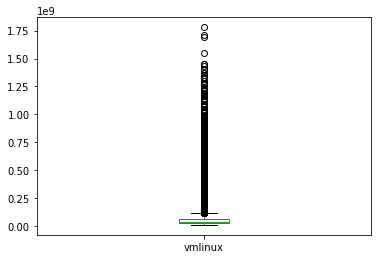

<Figure size 432x288 with 0 Axes>

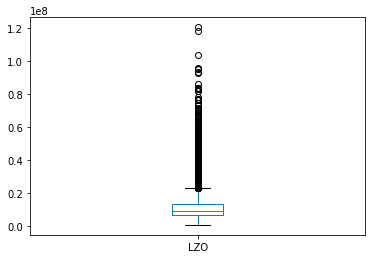

<Figure size 432x288 with 0 Axes>

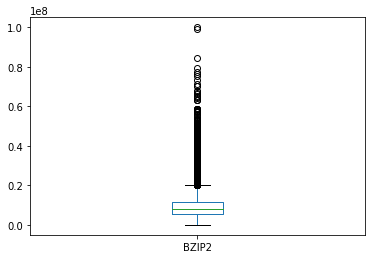

count    5.090800e+04
mean     5.951671e+07
std      8.292308e+07
min      7.317008e+06
25%      2.533070e+07
50%      3.669975e+07
75%      5.910926e+07
max      1.780630e+09
Name: vmlinux, dtype: float64

In [19]:
plt.figure()
pd.DataFrame(rawtuxdata['vmlinux']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['LZO']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['BZIP2']).plot.box()
plt.show(block=False)


rawtuxdata['vmlinux'].describe()


In [21]:
rawtuxdata['vmlinux'].sort_values()[:100]

33982     7317008
41789    10572520
14992    10786744
9653     10790352
35244    10856456
41192    10857304
47556    10865408
3174     10870272
50318    10889536
51557    10892608
6006     10908568
42479    10918504
38995    10955056
51787    10962488
43140    10981392
39577    10992912
18425    10994728
28532    11035016
47797    11035128
20769    11044640
18448    11064288
24865    11098984
27750    11100872
48773    11105984
50298    11116560
42483    11117600
38307    11120888
27266    11123472
45127    11129920
52693    11133784
           ...   
49055    11398144
28960    11398632
36820    11414584
2778     11419536
8661     11420632
20683    11426320
15394    11440248
15919    11447096
49219    11463608
41635    11466488
46371    11469576
52373    11481176
52457    11481752
38902    11488184
1097     11495296
7542     11495976
53712    11497832
10150    11498032
41039    11498440
36628    11502176
43290    11504128
30599    11514448
44479    11525112
30196    11532960
49910    1

In [22]:
import scipy.stats
import seaborn as sns



def color_negative_positive(val, pcolor="green", ncolor="red"):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = pcolor if val > 0 else ncolor 
    if val == 0:
        color = 'black' 
    return 'color: %s' % color

compress_methods = ["GZIP", "BZIP2", "LZMA", "XZ", "LZO", "LZ4"]
def compareCompress(size_measure_of_interest): #"" # "-vmlinux" #"-bzImage" # prefix
    rCompressDiff = pd.DataFrame(index=list(map(lambda c: c + "o", compress_methods)) , columns=compress_methods) 
    for compress_method in compress_methods:
        for compress_method2 in compress_methods:
            rCompressDiff.loc[compress_method + "o"][compress_method2] = (np.mean(rawtuxdata[compress_method + size_measure_of_interest] / rawtuxdata[compress_method2 + size_measure_of_interest]) * 100) - 100
    return rCompressDiff

#cmy = sns.light_palette("red", as_cmap=True)
compareCompress("").style.set_caption('Difference (average in percentage) per compression methods').applymap(color_negative_positive)

,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,2.95928,24.4634,38.2247,-10.0202,-21596.5
BZIP2o,-2.80728,0,20.9728,34.3205,-12.582,-20767.7
LZMAo,-19.5916,-17.2119,0,11.0617,-27.6178,-16985.9
XZo,-16472,-16469.9,-16454.3,0,-34.5915,-15747.1
LZOo,-31401.9,-31398.7,-31374.6,53.7674,0,-23993.4
LZ4o,-34283.2,-34279.7,-34253.9,64.9045,7.18129,0


In [23]:
compareCompress("-bzImage").style.set_caption('Difference (average in percentage) per compression methods, bzImage').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-32.2473,24.0531,37.1896,-9.68667,-15.7225
BZIP2o,52.0025,0,88.0169,107.487,37.3768,28.2427
LZMAo,-19.3246,-45.4972,0,10.5908,-27.107,-31.9646
XZo,-26.7877,-50.6265,-9.25183,0,-33.8565,-38.2629
LZOo,10.7922,-24.8779,37.5106,52.0561,0,-6.70738
LZ4o,18.8086,-19.4076,47.4979,63.1021,7.20516,0


In [24]:
compareCompress("-vmlinux").style.set_caption('Difference (average in percentage) per compression methods, vmlinux').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-27.0566,18.3622,27.679,-7.85463,-12.9035
BZIP2o,38.956,0,63.8816,76.4653,28.2032,21.2723
LZMAo,-15.4001,-38.5103,0,7.83575,-21.9953,-26.2438
XZo,-21.3511,-42.9332,-7.06623,0,-27.4755,-31.4183
LZOo,8.5874,-20.6908,28.6183,38.754,0,-5.50588
LZ4o,14.9691,-15.962,36.2331,46.9831,5.84438,0


In [25]:
cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.corr(rawtuxdata[size_methods]).style.set_caption('Correlations between size measures').background_gradient(cmap=cm)


,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,LZMA-bzImage,LZMA-vmlinux,LZMA,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4
vmlinux,1,0.502302,0.502328,0.500853,0.516226,0.516128,0.514954,0.488742,0.488778,0.486779,0.493102,0.493141,0.491771,0.518695,0.518918,0.518195,0.525289,0.525527,0.524892
GZIP-bzImage,0.502302,1,1,0.999901,0.997318,0.996843,0.997402,0.997672,0.997674,0.997511,0.993541,0.993542,0.993461,0.997179,0.9972,0.997328,0.994144,0.994167,0.994305
GZIP-vmlinux,0.502328,1,1,0.9999,0.997323,0.996848,0.997407,0.997671,0.997673,0.997509,0.99354,0.993541,0.993459,0.997183,0.997205,0.997332,0.99415,0.994173,0.994311
GZIP,0.500853,0.999901,0.9999,1,0.997079,0.996603,0.997325,0.99756,0.99756,0.997662,0.993533,0.993533,0.993484,0.997024,0.996978,0.997125,0.993926,0.993876,0.994031
BZIP2-bzImage,0.516226,0.997318,0.997323,0.997079,1,0.999529,0.999934,0.99411,0.994118,0.99376,0.990946,0.990955,0.990612,0.998408,0.99842,0.998392,0.997279,0.997291,0.997288
BZIP2-vmlinux,0.516128,0.996843,0.996848,0.996603,0.999529,1,0.999462,0.993633,0.993642,0.993281,0.990458,0.990467,0.990122,0.997945,0.997956,0.997928,0.996821,0.996833,0.996829
BZIP2,0.514954,0.997402,0.997407,0.997325,0.999934,0.999462,1,0.994192,0.994199,0.994057,0.991109,0.991117,0.990806,0.998413,0.998371,0.998362,0.997218,0.997172,0.997187
LZMA-bzImage,0.488742,0.997672,0.997671,0.99756,0.99411,0.993633,0.994192,1,1,0.999823,0.993746,0.993746,0.993725,0.991144,0.991185,0.991346,0.986434,0.986479,0.986645
LZMA-vmlinux,0.488778,0.997674,0.997673,0.99756,0.994118,0.993642,0.994199,1,1,0.999822,0.993746,0.993746,0.993725,0.991152,0.991193,0.991353,0.986445,0.986489,0.986655
LZMA,0.486779,0.997511,0.997509,0.997662,0.99376,0.993281,0.994057,0.999823,0.999822,1,0.993708,0.993706,0.993728,0.990905,0.990855,0.991042,0.98611,0.986056,0.986246


In [26]:
#from category_encoders import *
from sklearn.preprocessing import *

## class to integer encoding (y, n, m)

## note: we also remove non-tristate-options
# "in place" is to avoid memory burden (having two dfs in memory)

# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()
# 2/3. FIT AND TRANSFORM
vml = rawtuxdata[size_methods]

# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
#tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
rawtuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(le.fit_transform)

#tuxdata['vmlinux'] = vml 
rawtuxdata[size_methods] = vml
 
rawtuxdata.shape, rawtuxdata.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50908 entries, 0 to 53909
Columns: 9725 entries, X86_LOCAL_APIC to LZ4
dtypes: int64(9725)
memory usage: 3.7 GB


((50908, 9725), None)

In [27]:
#### takes a while
# One-Hot-Encoding 
#from sklearn.preprocessing import *

#enc = OneHotEncoder()
#o_sizes = rawtuxdata[size_methods]
#oh_tuxdata = enc.fit_transform(rawtuxdata)
#oh_tuxdata.shape, o_sizes.shape
# rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(enc.fit_transform)
#oh_tuxdata[size_methods] = o_sizes

In [28]:
# DUMMY (with Pandas)

#o_sizes = tuxdata[size_methods]
#tuxdata_dummy = pd.get_dummies(rawtuxdata.drop(columns=size_methods), columns=rawtuxdata.drop(columns=size_methods).columns)
#tuxdata_dummy[size_methods] = o_sizes
#tuxdata_dummy.shape

In [29]:
# Data exploration (again)
#print(rawtuxdata['UBSAN_SANITIZE_ALL'].value_counts(), rawtuxdata['COMPILE_TEST'].value_counts(), rawtuxdata['NOHIGHMEM'].value_counts(), rawtuxdata['OPTIMIZE_INLINING'].value_counts(), rawtuxdata['SLOB'].value_counts(), rawtuxdata['CC_OPTIMIZE_FOR_SIZE'].value_counts(), sep='\n')

In [30]:
from enum import Enum
class LearningStrategy(Enum):
    LINEAR = 1
    AUTOML = 2
    ML = 3

In [31]:
from sklearn.pipeline import Pipeline

# https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.decomposition import PCA
from tpot import TPOTRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.neural_network import MLPRegressor





# drop(columns=["date", "time", "vmlinux", "cid"])
# tuxdata.drop(columns=non_tristate_options)

NO_ENCODED_VALUE = le.transform(['n'])[0] 

def mkNoOption(option_name):
    return "(" + option_name + " == " + str(NO_ENCODED_VALUE) + ")"

def prefilter_data(tuxdata):    
    return rawtuxdata
    #return rawtuxdata.query(mkNoOption("DEBUG_INFO"))
    #return rawtuxdata.query(mkNoOption("DEBUG_INFO") + " & " + mkNoOption("GCOV_PROFILE_ALL") + " & " + mkNoOption("KASAN") + " & " + mkNoOption("UBSAN_SANITIZE_ALL") + " & " + mkNoOption("RELOCATABLE") + " & " + mkNoOption("XFS_DEBUG"))
                

def regLearning(tuxdata, kindOfLearning=LearningStrategy.ML):
 
    TESTING_SIZE=0.3 # 0.9 means 10% for training, 90% for testing
    size_of_interest = "vmlinux" # could be LZO, BZIP, etc. 
    PRINT_FEATURE_IMPORTANCES = True
   
       
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])].drop(columns=size_methods), tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])][size_of_interest], test_size=TESTING_SIZE, random_state=0)  
    print ("Warning: prefiltering on DEBUG_INFO=n GCOV_PROFILE_ALL=n KASAN=n ....")   
    X_train, X_test, y_train, y_test = train_test_split(prefilter_data(tuxdata).drop(columns=size_methods), prefilter_data(tuxdata)[size_of_interest], test_size=TESTING_SIZE, random_state=0)  
  
    # multi output
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=size_methods), tuxdata[size_methods], test_size=TESTING_SIZE, random_state=0)  

    # train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  

    #clf = RandomForestRegressor(n_estimators=100) 

    if kindOfLearning == LearningStrategy.LINEAR:
        regr =  linear_model.Lasso() # svm.SVC(kernel='linear') # linear_model.Ridge(alpha=.1) #  # linear_model.Lasso() # linear_model.SGDRegressor() #LinearRegression() # SGDRegressor or linear_model.Lasso()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)

    elif kindOfLearning == LearningStrategy.AUTOML:


        tpot_config = {

            'sklearn.linear_model.ElasticNetCV': {
                'l1_ratio': np.arange(0.0, 1.01, 0.05),
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
            },

            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.ensemble.GradientBoostingRegressor': {
                'n_estimators': [100],
                'loss': ["ls", "lad", "huber", "quantile"],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'subsample': np.arange(0.05, 1.01, 0.05),
                'max_features': np.arange(0.05, 1.01, 0.05),
                'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
            },

            'sklearn.ensemble.AdaBoostRegressor': {
                'n_estimators': [100],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'loss': ["linear", "square", "exponential"],
                'max_depth': range(1, 11)
            },

            'sklearn.tree.DecisionTreeRegressor': {
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21)
            },

            'sklearn.neighbors.KNeighborsRegressor': {
                'n_neighbors': range(1, 101),
                'weights': ["uniform", "distance"],
                'p': [1, 2]
            },

            'sklearn.linear_model.LassoLarsCV': {
                'normalize': [True, False]
            },

            'sklearn.svm.LinearSVR': {
                'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
                'dual': [True, False],
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
                'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
            },

            'sklearn.ensemble.RandomForestRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.linear_model.RidgeCV': {
            },

            'xgboost.XGBRegressor': {
                'n_estimators': [100],
                'max_depth': range(1, 11),
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'subsample': np.arange(0.05, 1.01, 0.05),
                'min_child_weight': range(1, 21),
                'nthread': [1]
            }     
        }

        tpot = TPOTRegressor(generations=5, population_size=50, verbosity=3, config_dict=tpot_config, scoring='neg_mean_absolute_error')
        tpot.fit(X_train, y_train)
        y_pred = tpot.predict(X_test)
        print(tpot.score(X_test, y_test))
        print(tpot.evaluated_individuals_)
        tpot.export('tpot_boston_pipeline.py')

    else:
        assert (kindOfLearning == LearningStrategy.ML)
        clf = GradientBoostingRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) #GradientBoostingRegressor(n_estimators=100) # KNeighborsRegressor() #RandomForestRegressor(n_estimators=100) # linear_model.SGDRegressor(alpha=0.15, max_iter=200)
        # #LassoLarsCV() # MLPRegressor() # GradientBoostingRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #  #   GradientBoostingRegressor(n_estimators=100) # 
        # 
        #estimator = RandomForestRegressor(n_estimators=100) # RidgeCV(alphas=[1000.0]) # LassoCV(tol = 0.001) #   #  # RandomForestRegressor(n_estimators=100) #LassoCV() #RidgeCV(alphas=[2000.0]) # LassoCV()
        #clf = PipelineRFE([ # Pipeline([
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = PipelineRFE([
          #('reduce_dim', PCA()),
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = make_pipeline(
        #    StackingEstimator(estimator=LassoLarsCV(normalize=False)),
        #    StackingEstimator(estimator=RandomForestRegressor(bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=10, min_samples_split=2, n_estimators=100)),
        #    KNeighborsRegressor(n_neighbors=82, p=2, weights="distance")
        #)


        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if PRINT_FEATURE_IMPORTANCES:
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]    

            TOP_FT_IMPORTANCE=100
            print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
            for f in range(TOP_FT_IMPORTANCE): # len(indices)
                print("%d. feature %s %d (%f)" % (f + 1, tuxdata.columns[indices[f]], indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    #plt.figure()
    #plt.title("Feature importances for size of vmlinux")
    #plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
    #plt.xticks(range(tuxdata.shape[1]), indices)
    #plt.xlim([-1, tuxdata.shape[1]])
    #plt.show()
    mae = mean_absolute_error (y_test, y_pred)# , multioutput='raw_values')
    mse = mean_squared_error (y_test, y_pred) #, multioutput='raw_values') 
    r2 = r2_score (y_test, y_pred) #, multioutput='raw_values') 
    mre = mean_relative_error (y_test, y_pred)

    ONE_MEGABYTE = 1048576

    print("Prediction score (MAE): %.2f" % (mae / ONE_MEGABYTE))
    print("Prediction score (MSE): %.2f" % (mse / ONE_MEGABYTE))
    print("Prediction score (R2): %.2f" % (r2))
    print("Prediction score (MRE): %.2f" % (mre))
    return y_pred, y_test
    
pr, re = regLearning(rawtuxdata, LearningStrategy.ML)
#regLearning(tuxdata_dummy)


In [ ]:
#re[56589]


In [ ]:
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.feature_selection import SelectFromModel

#model = SelectFromModel(clf, prefit=True)
#tuxdata_reduced = model.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced.shape, tuxdata.shape


In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import LinearSVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE


#alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]
#selector = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]) # LassoCV(tol = 0.001) # RidgeCV(alphas=[2000.0])  # 
#lass = selector #SelectFromModel(selector) #  RFECV(estimator=selector, step=1, scoring='neg_mean_squared_error') # 
#lass = RFE(estimator=selector, step=1)
#lass.fit(X_train, y_train)
#tuxdata_reduced_lass = lass.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_lass.shape, tuxdata.shape  
#lass.alpha_ 



In [ ]:
#from sklearn.decomposition import PCA

#pca = PCA(n_components=100)
#pca.fit(X_train, y_train)

#tuxdata_reduced_pca = pca.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_pca.shape, tuxdata.shape  

#pca.components_.shape

#plt.matshow(pca.components_, cmap='viridis')
#plt.yticks([0, 1], ["First component", "Second component"])
#plt.colorbar()
#plt.xticks(range(len(X_train.columns)),
#           X_train.columns, rotation=60, ha='left')
#plt.xlabel("Feature")
#plt.ylabel("Principal components")

In [ ]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

In [ ]:
#for tux1 in tuxdata:
#    ft1 = tuxdata[tux1]
#    for tux2 in tuxdata:
#        if (tux1 != tux2):
#            if (ft1.all() == tuxdata[tux2].all()):
#                print ("feature " + str(tux1) + " always have the same values than " + str(tux2))
            
    

In [ ]:
#provisoire = pd.read_csv(open('provisoire.csv', "r"))

In [ ]:
#provisoire[['cid','CC_OPTIMIZE_FOR_SIZE']]

In [ ]:
#rawtuxdata.columns[6015] #Columns (1150,6015,6026,7676,7726)

In [ ]:
#size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
#              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
#              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]
#size_methods_without_soi

In [ ]:
#import h2o
#from h2o.automl import H2OAutoML
#h2o.init()
#df = h2o.import_file(TUXML_CSV_FILENAME)

In [ ]:
#df.describe()

In [ ]:
#splits = df.split_frame(ratios = [0.8], seed = 1)
#train = splits[0]
#test = splits[1]

In [ ]:
#y = size_of_interest
#aml = H2OAutoML(max_runtime_secs = 36000, seed = 1, project_name = "tuxlearning")
#aml.train(y = y, training_frame = train, leaderboard_frame = test)

In [ ]:
#aml.leaderboard.head()

In [ ]:
#pred = aml.predict(test)
#pred.head()

In [ ]:
#perf = aml.leader.model_performance(test)
#perf

In [ ]:
#h2o.shutdown()

In [ ]:
#import category_encoders as ce

#colmatters = list(tuxdata.columns)
#for s in size_methods:
#    colmatters.remove(s)
    
# colmatters.remove(size_methods)
#encoder = ce.OneHotEncoder(cols=colmatters) #cols=tuxdata.drop(columns=size_methods).columns

#o_sizes = tuxdata[size_methods]
#encoder.fit(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2 = encoder.transform(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2[size_methods] = o_sizes

In [ ]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]#['MODULES']

In [ ]:
#tuxdata_dummy2.shape, tuxdata.shape

In [ ]:
#rawtuxdata[(rawtuxdata['MODULES'] == 'y')]['vmlinux'].describe(), rawtuxdata[(rawtuxdata['MODULES'] == 'n')]['vmlinux'].describe()
#rawtuxdata[(rawtuxdata['UBSAN_SANITIZE_ALL'] == 'y')]
# [['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]

In [ ]:
rawtuxdata.info(memory_usage='deep')